# Setup

## Imports

In [1]:
from vaiutils import path_consts, plot_images, channels_last
from tqdm import tqdm_notebook

In [2]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST

## Set up data and variables

In [3]:
for k, v in path_consts('VAE', 'MNIST'):
    exec(k + '=v')

In [4]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])
dataset = MNIST(DIR_DATA, transform=transform)
data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

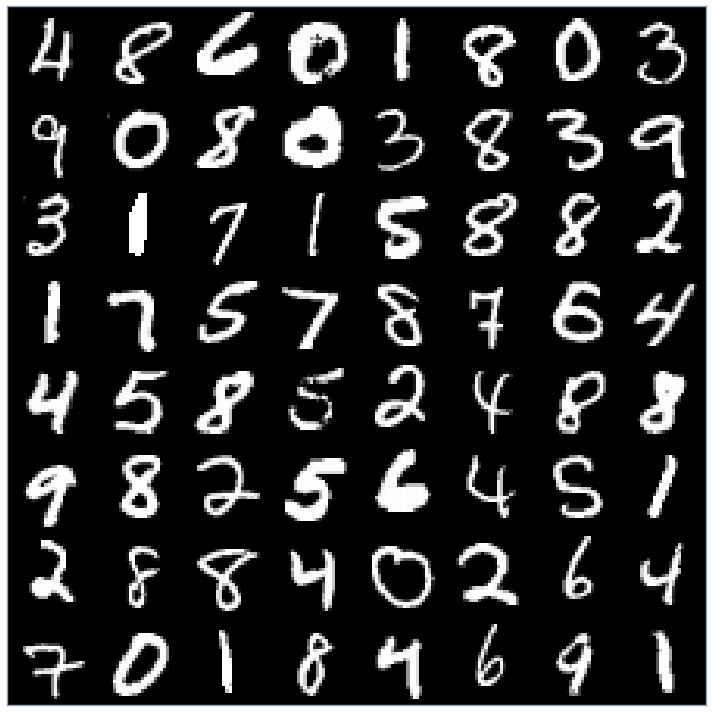

In [5]:
plot_images(channels_last(iter(data).next()[0].cpu().numpy()))

# Create Model

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc_mean = nn.Linear(28 * 28 * 1, 32)
        self.fc_std = nn.Linear(28 * 28 * 1, 32)
    def forward(self, x):
        mean = F.relu(self.fc_mean(x.view(-1, 28 * 28 * 1)))
        std = self.fc_std(x.view(-1, 28 * 28 * 1))
        return mean, std

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(32, 28 * 28 * 1)

    def forward(self, x):
        x = self.fc1(x)
        return F.sigmoid(x.view(-1, 1, 28, 28))

In [8]:
encoder = Encoder().cuda()
decoder = Decoder().cuda()

# Train Model

In [9]:
gen_criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) +
                       list(decoder.parameters()), lr=1e-3)

In [12]:
history = {'gen_loss': [], 'latent_loss':[]}


def optimize(epochs=1):
    for epoch in tqdm_notebook(range(epochs)):
        for batch, datum in enumerate(tqdm_notebook(data)):
            x_batch = Variable(datum[0].cuda())
            epsilon = Variable(torch.randn(x_batch.data.shape[0], 32).cuda())
            
            optimizer.zero_grad()
            mean, std = encoder(x_batch)
            x_gen_batch = decoder(epsilon*std+mean)
            gen_loss = gen_criterion(x_gen_batch, x_batch)
            latent_loss = 0.5 * (mean**2+torch.exp(-std)-std-1).mean()
            loss = gen_loss + 1e-2*latent_loss
            loss.backward()
            optimizer.step()

            history['gen_loss'].append(gen_loss.cpu().data.numpy()[0])
            history['latent_loss'].append(latent_loss.cpu().data.numpy()[0])
            if batch % 400 == 0:
                plot_images(channels_last(x_batch[:5].cpu().data.numpy()))
                plot_images(channels_last(x_gen_batch[:5].cpu().data.numpy()))

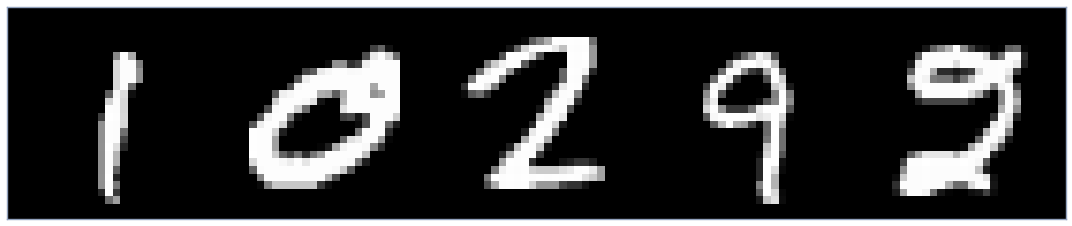

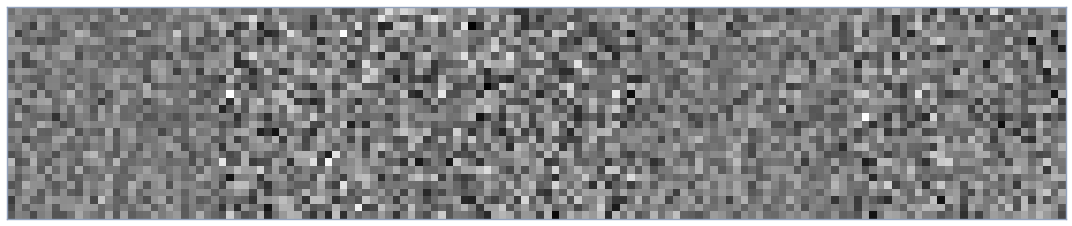

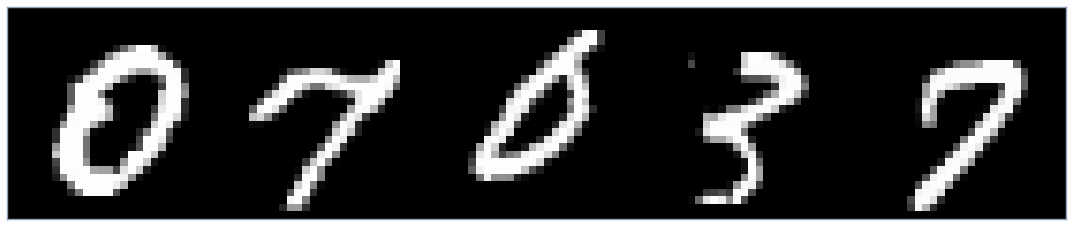

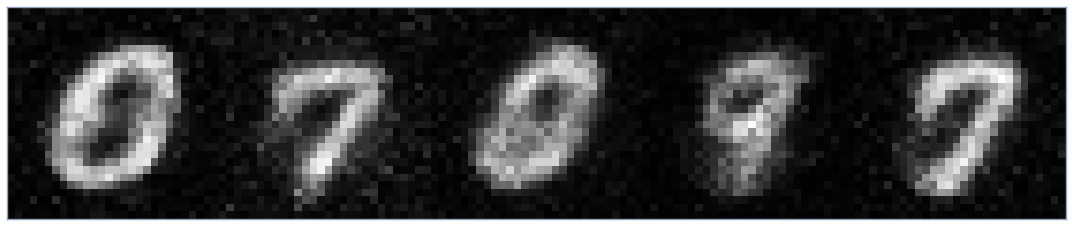

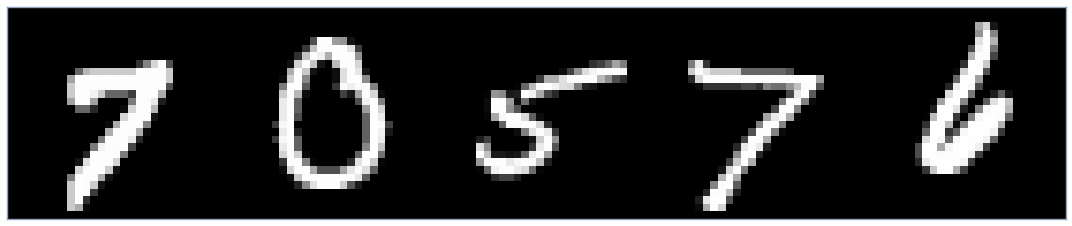

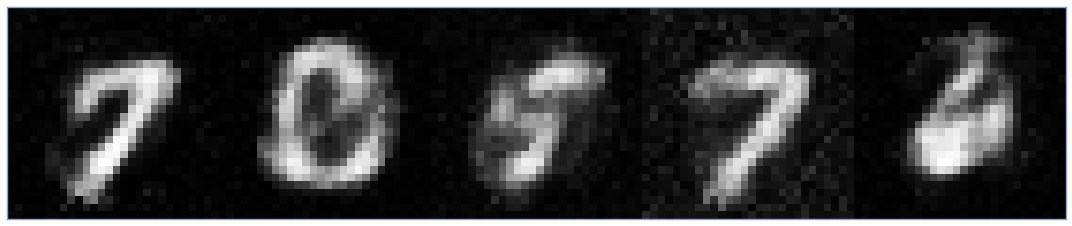

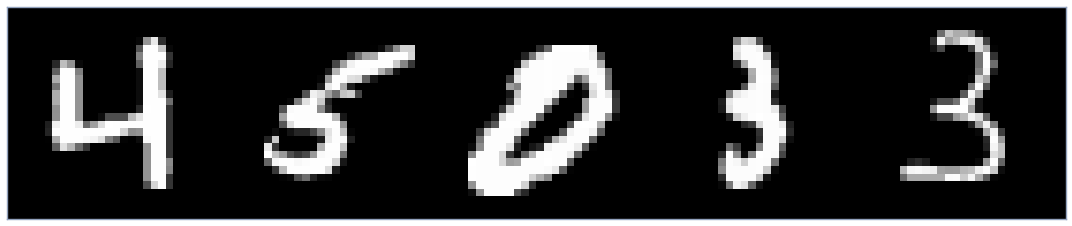

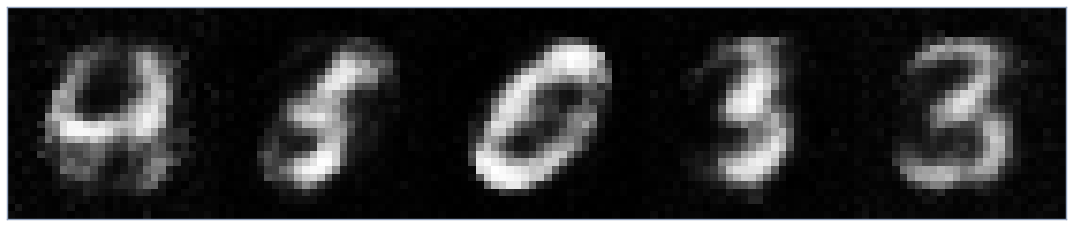

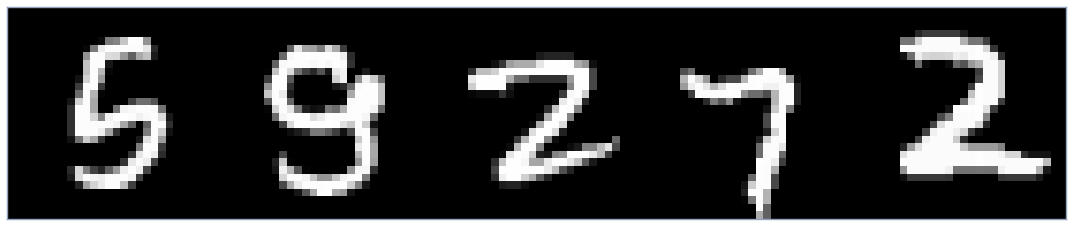

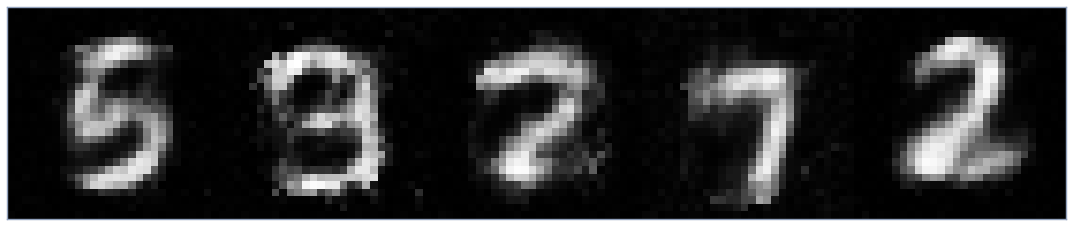

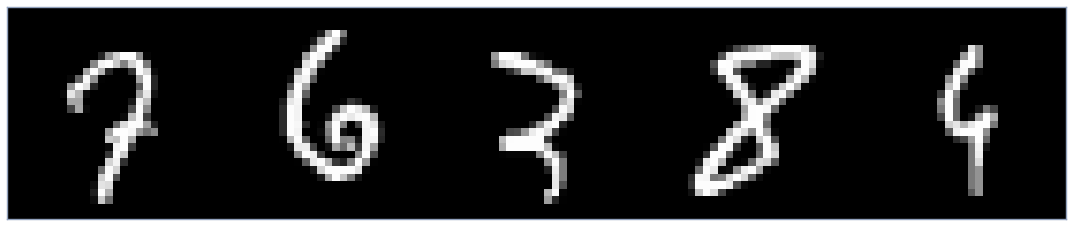

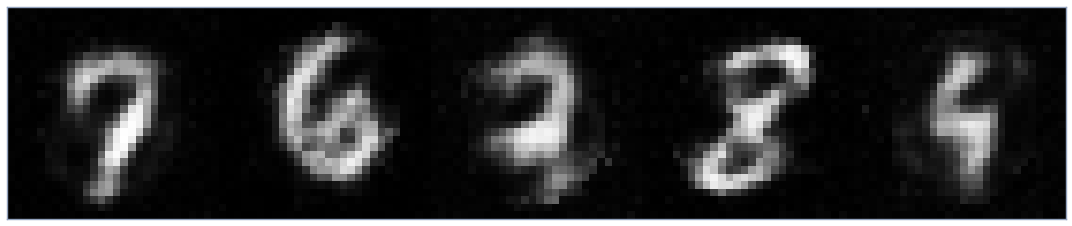

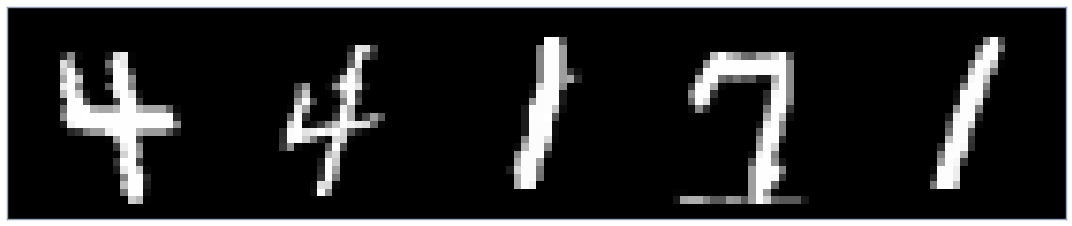

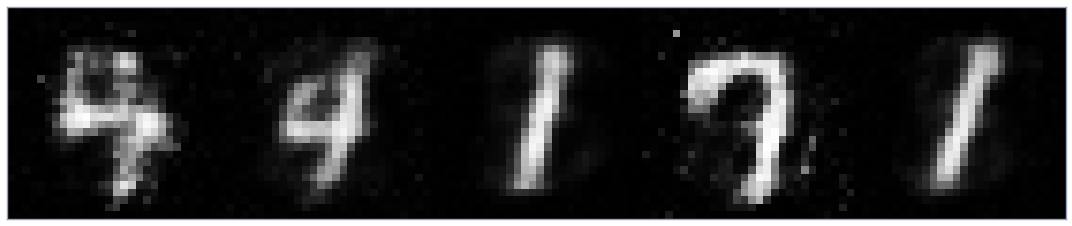

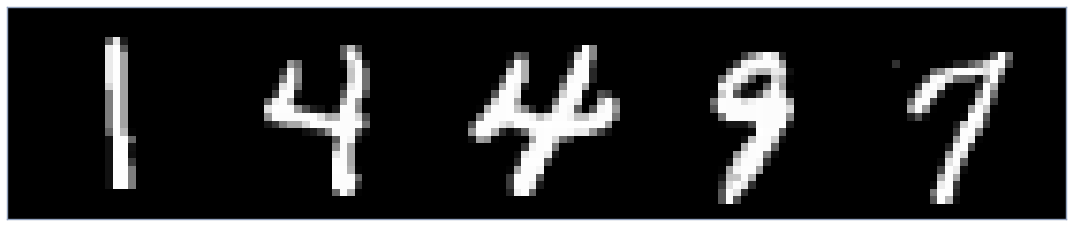

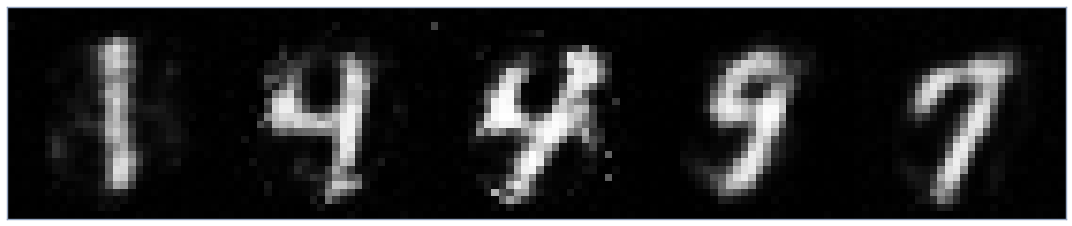

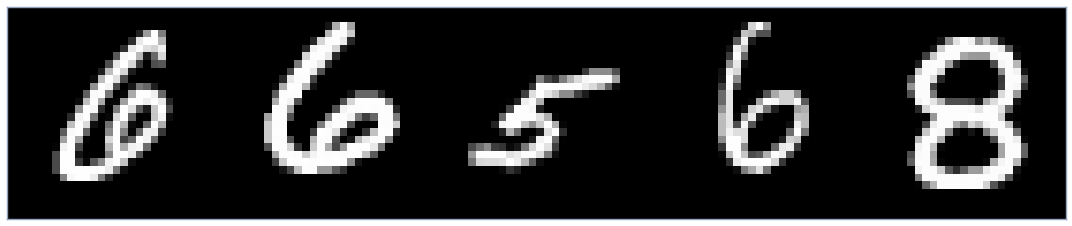

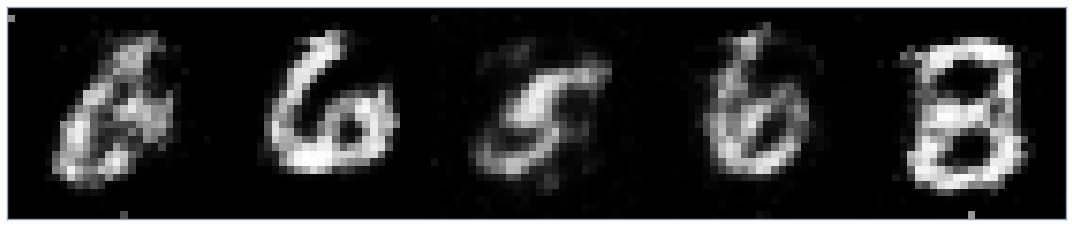

In [13]:
optimize(3)

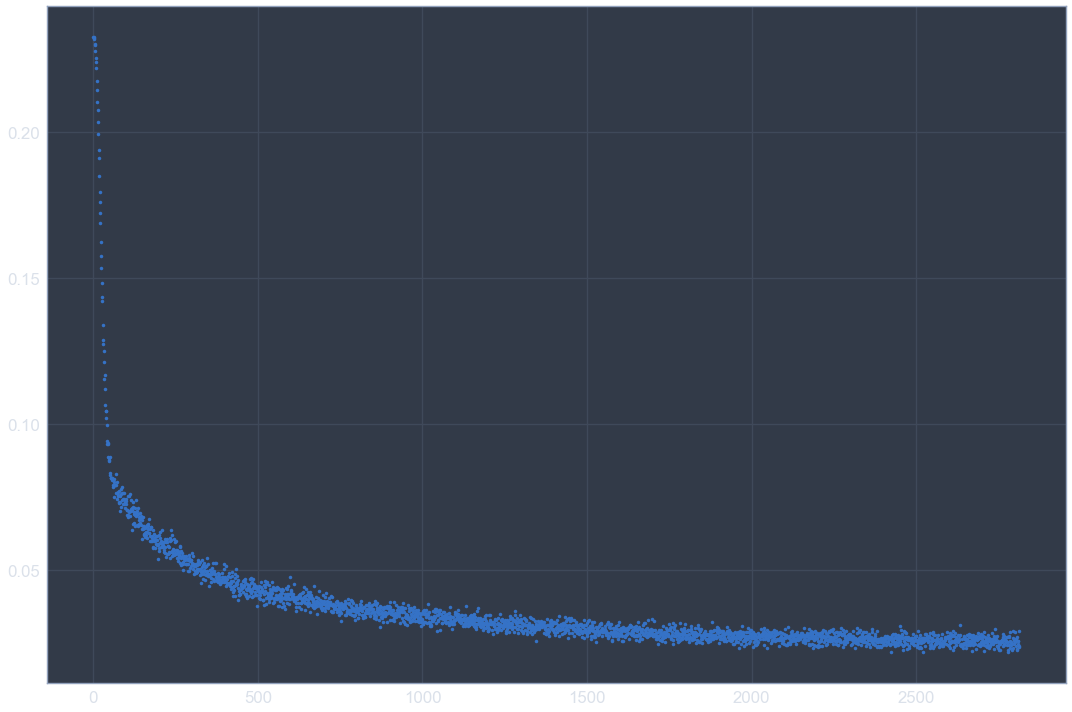

(0.029076146, -41.137791)

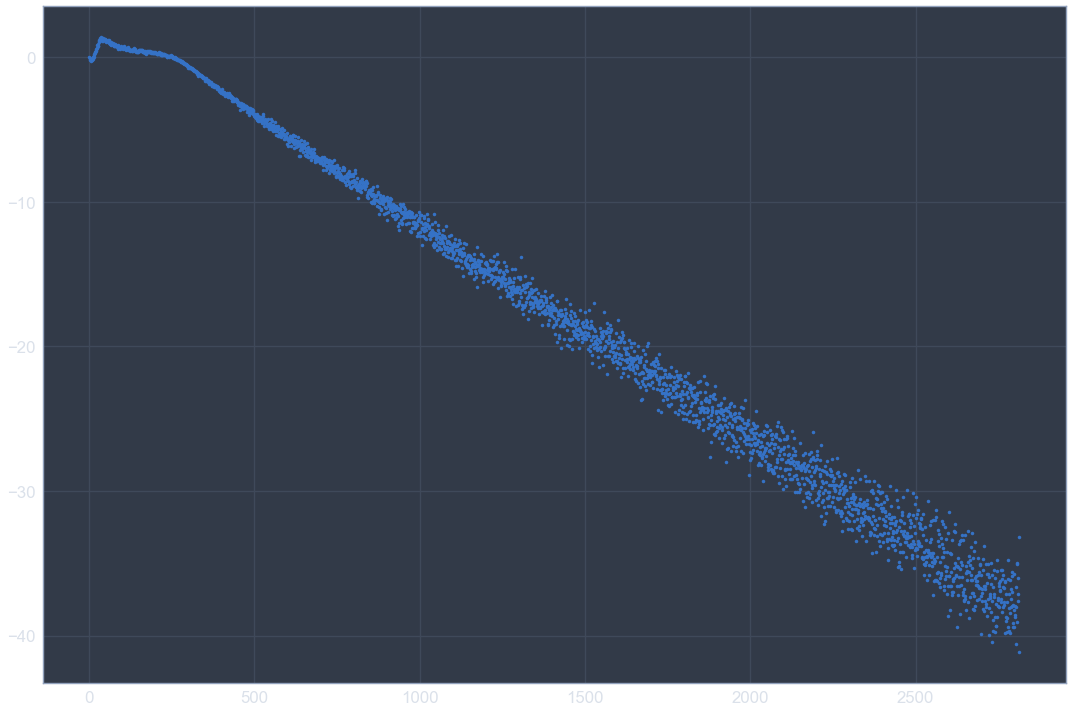

In [14]:
plot(history['gen_loss'], '.')
plt.show()
plot(history['latent_loss'], '.')
history['gen_loss'][-1], history['latent_loss'][-1]

# Generate Images

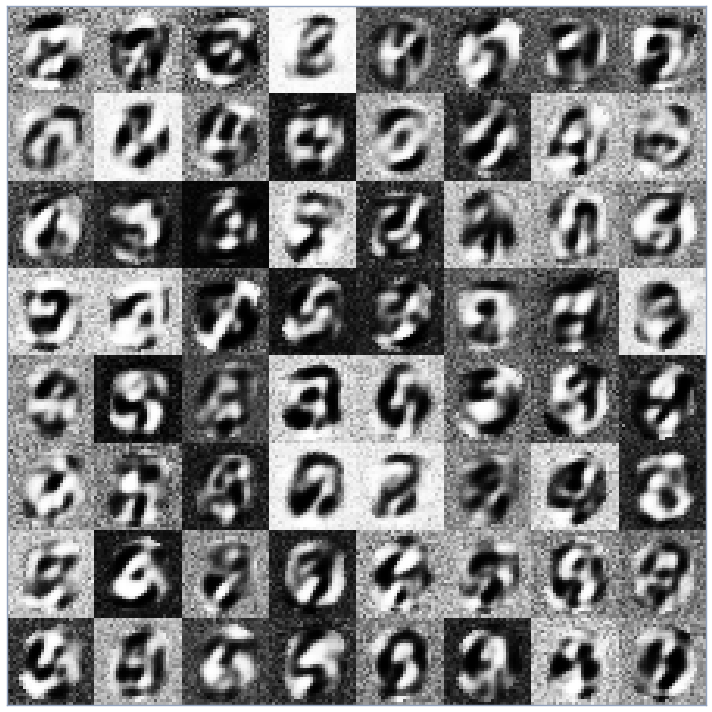

In [15]:
z_rand = torch.randn(64, 32)
gen_imgs = decoder(Variable(z_rand.cuda()))
plot_images(channels_last(gen_imgs.cpu().data.numpy()))